# Kunitz domain notebook. 
The Kunitz domain is a family of protease inhibitors. It is one of the simplest and shortest ($N = 53$) domain, with a well-known secondary and tertiary structure (2 beta strands, 2 alpha-helices, 3 disulfide bridges). We show here some features found by the algorithm, as well as contact predictions.

## Loading data and packages

0
1000
2000
3000
4000
5000
6000
7000
8000
Effective number of sequences Beff: 5496.98


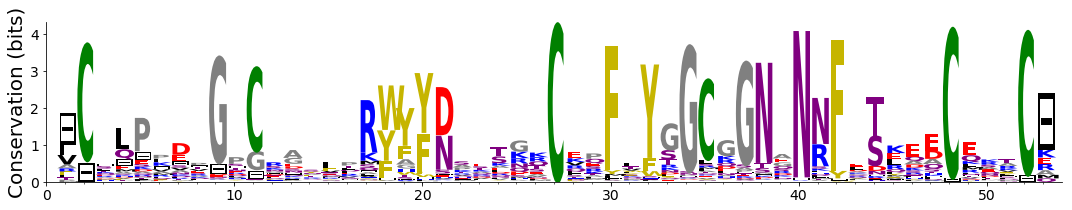

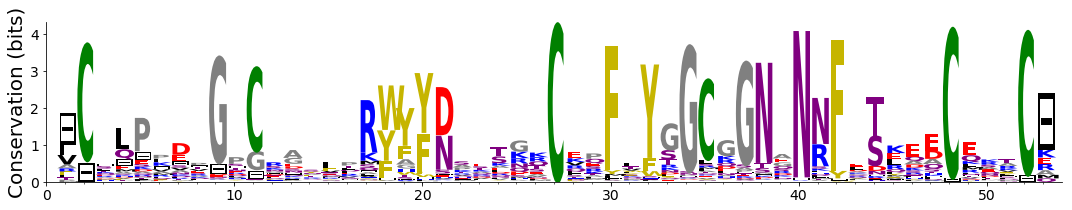

In [ ]:
%matplotlib inline
import sys,os,pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('RBM/')
sys.path.append('utilities/')

try:
    import rbm
except:
    print 'Compiling cy_utilities first' # the RBM package contains cython files that must be compiled first.
    curr_dir = os.getcwd()
    os.chdir('RBM/')
    !python setup.py build_ext --inplace
    print 'Compilation done'
    os.chdir(curr_dir)
    import rbm


import Proteins_utils, Proteins_RBM_utils, utilities,sequence_logo,plots_utils





filename = 'Kunitz_domain_MSA.fasta'
path = u'data/Kunitz/'

all_data = Proteins_utils.load_FASTA(path+filename,drop_duplicates=True)

seed = utilities.check_random_state(0) 
permutation = np.argsort(seed.rand(all_data.shape[0]))
all_data = all_data[permutation] # Shuffle data.

num_neighbours= Proteins_utils.count_neighbours(all_data)
all_weights = 1.0/num_neighbours

print 'Effective number of sequences Beff: %.2f'%all_weights.sum()


mu = utilities.average(all_data,c=21,weights=all_weights)
sequence_logo.Sequence_logo(mu,ticks_every=5,figsize=(15,3))


## Learning

In [ ]:
make_training = True
n_v = 53 # Number of visible units; = # sites in alignment.
n_h = 100 # Number of hidden units.
visible = 'Potts' # Nature of visible units potential. Here, Potts states...
n_cv = 21 # With n_cv = 21 colors (all possible amino acids + gap)
hidden = 'dReLU' # Nature of hidden units potential. Here, dReLU potential.
seed = 0 # Random seed (optional)
if make_training:
    RBM = rbm.RBM(visible = visible,hidden = hidden,n_v = n_v,n_h = n_h, n_cv = n_cv, random_state = seed)

    batch_size = 100 # Size of mini-batches (and number of Markov chains used). Default: 100.
    n_iter = 2000 # Number of epochs
    learning_rate = 0.1 # Initial learning rate (default: 0.1)
    decay_after = 0.25 # Decay learning rate after 50% of iterations (default: 0.5)
    l1b = 0.25 # L1b regularization. Default : 0.
    N_MC = 1 # Number of Monte Carlo steps between each update

    RBM.fit(all_data, weights= all_weights, batch_size = batch_size,
        n_iter = n_iter, l1b = l1b, N_MC = N_MC, 
       decay_after = decay_after, verbose = 0 )
    
else:    
    RBM = Proteins_RBM_utils.loadRBM('models/RBM_Kunitz_Domain.data') ## Alternative: Load previous model.

Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20


## Evaluate accuracy of training: Train and test set likelihood

In [ ]:
RBM.AIS(n_betas=20000,verbose=1) # Compute partition function with annealed importance sampling
print utilities.average(RBM.likelihood(all_data), weights=all_weights)/53


## Visualizing hidden units: Sequence logo of weights
Show sequence logos of some selected weights. Here, features reflect the structural constraint, as well as phylogenic diversity.


- Feature 1: The contact 45-49 within the alpha helix alpha2. Amino-acids at sites 45 and 49 cannot have identical charge.
- Feature 2: The disulfide bridge 11-35 may be present or absent. Most sequences that do not have the bridge come from nematode organisms.
- Feature 3: When the bridge 11-35 is missing, it may be replaced by an 'electrostatic triangle' 10-33-36 of amino-acids with alternate charges.
- Feature 4: A feature with multiple sites, localized around the beta1-beta2 turn.
- Feature 5: A 'Phylogenic feature': it is strongly activated only for a small subset of close sequences; here, sequences of the AMBP gene, present only in mammals.

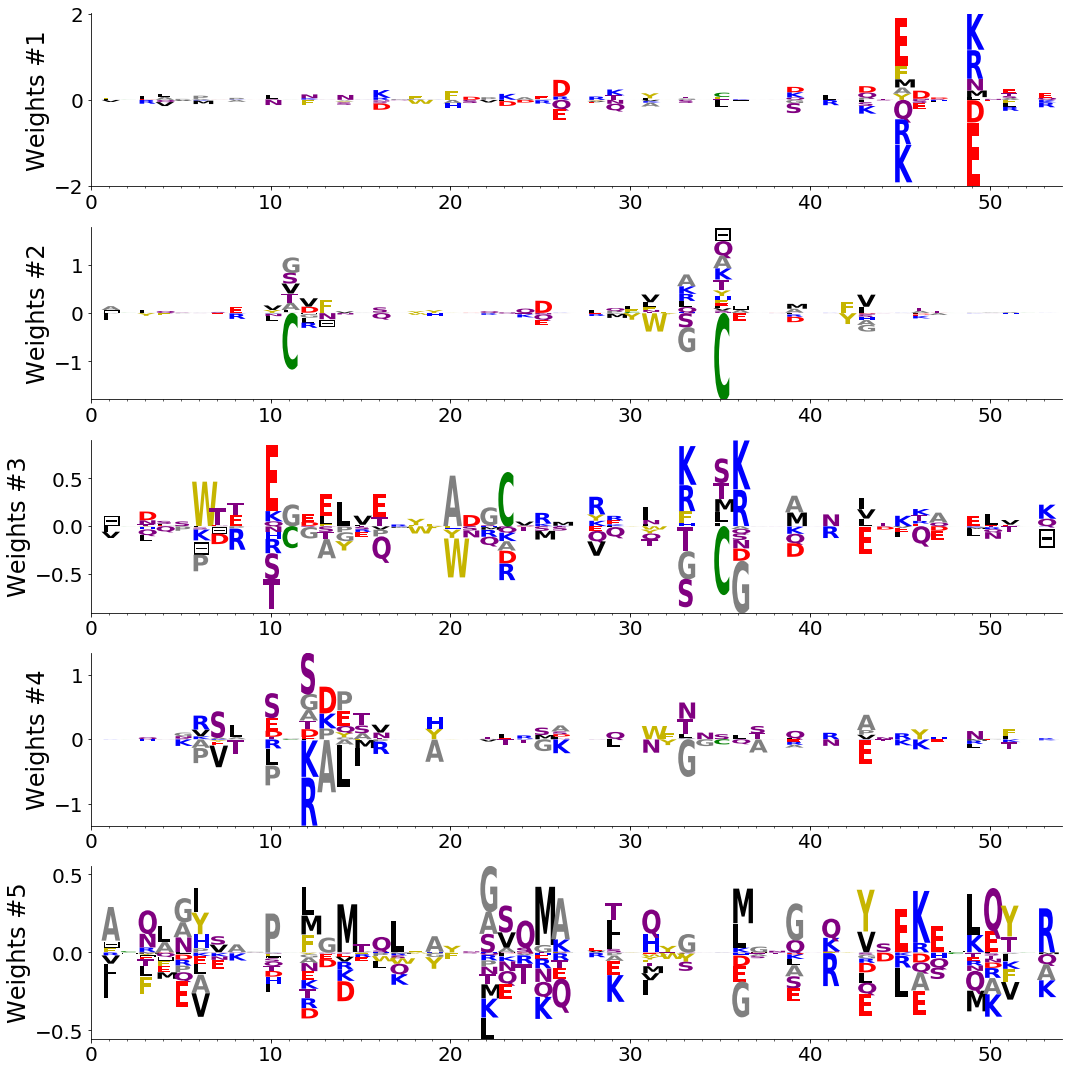

In [16]:
## Show some interesting features.

if make_training:
    interesting_features = [60,27,88,77,10] # After training.
else:
    beta = Proteins_RBM_utils.get_beta(RBM.weights)
    order = np.argsort(beta)[::-1]
    interesting_features = order[[24,10,51,52,91]] # If loading trained RBM.

nsites = len(interesting_features)
fig = sequence_logo.Sequence_logo_multiple(RBM.weights[interesting_features], figsize=(15,3) ,ticks_every=5,ticks_labels_size=20,title_size=24);


## Visualizing hidden units: Distribution of inputs and non-linearity.
Protein sequences cluster according to the projections onto the weights.

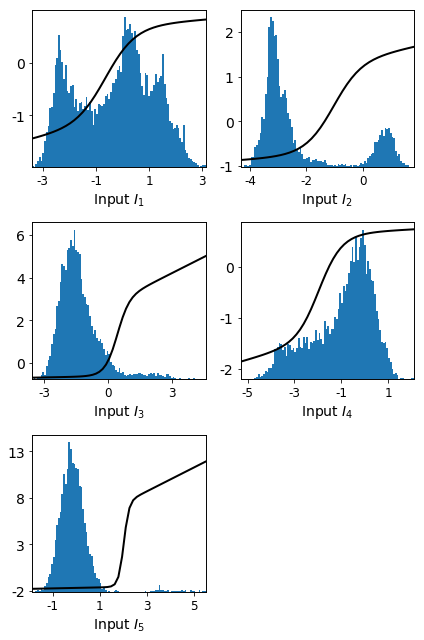

In [19]:
## Display their histograms of activations.

I = RBM.input_hiddens(all_data) # compute hidden unit input.
# Show inputs histogram and conditional means
plots_utils.plot_input_mean(RBM,I, interesting_features,ncols=2); 

## Visualizing hidden units: Phylogenic activity.
Are the features active across all, or only a portion of the phylogenic tree ? To assess this, we pick for each hidden unit the 20 sequences with highest $I_\mu$ (or lowest, depending on the sign of the non-linearity), and compute the distances between each pair. We compare to the background distribution of pairwise distances

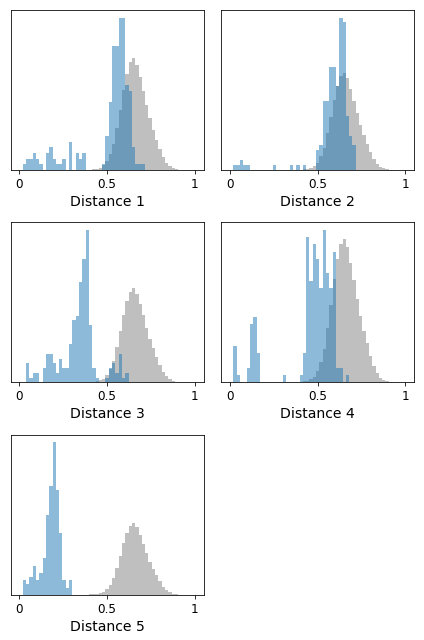

In [20]:
# Compute histogram of distances between top-activating sequences.
plots_utils.plot_top_activating_distance(RBM, I,all_data,interesting_features,ncols=2);

## Script for visualizing all hidden units into a single PDF. 
Requires  pdfjoin

In [21]:
# Make all the previous plots, for all hidden units into a same pdf. Requires the utility pdfjoin.
plots_utils.make_all_weights(RBM,all_data,nweights = 10, weights=None,name = 'all_weights_Kunitz.pdf',figsize=(15,3),sort='beta',dpi=200);

Make all weights: Done.


# Contact predictions with RBM
RBM can predict contact maps like Boltzmann Machines. First, we compute an effective coupling matrix from the epistasis landscape. Then we use it to predict contact maps using the Frobenius norm and the Average Product Correction. 

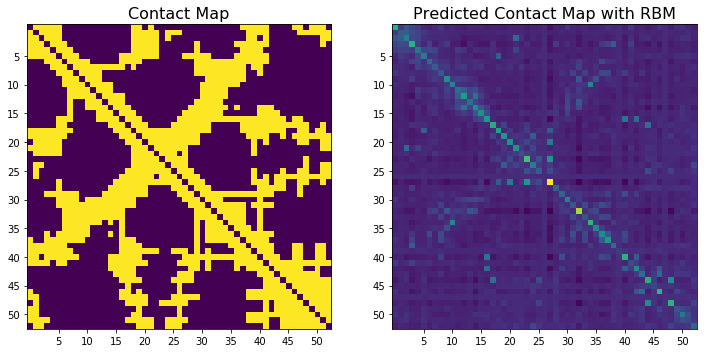

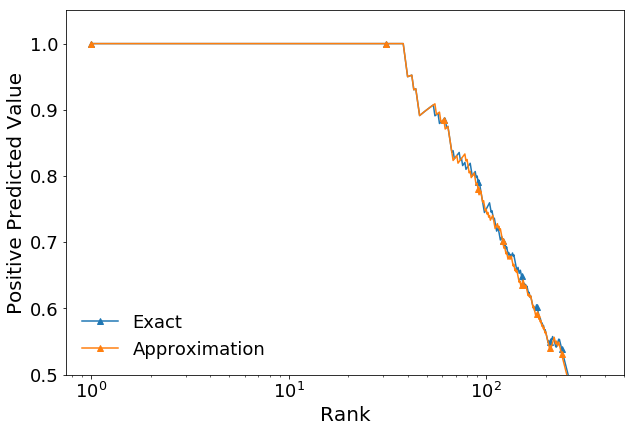

In [22]:
## Make contact predictions.

from scipy.io import loadmat
contact_map = loadmat(path+'contact_map14_extended.mat')['cm'] > 0 
contact_map += contact_map.T # Load contact map.



Jeff_approx = Proteins_RBM_utils.weights_to_couplings_approx(RBM,all_data,weights=all_weights) # Fast approximation of J_eff using a Taylor expansion of the cumulant generating function Phi.
# Jeff = Proteins_RBM_utils.weights_to_couplings_exact(RBM,all_data,weights=all_weights) # Full computation, by averaging the epistasis landscapes for all sequences in the alignment. Takes a while...
# Jeff = Jeff_approx.copy()

F_approx = Proteins_RBM_utils.couplings_to_contacts(Jeff_approx,with_gaps=True)
F = Proteins_RBM_utils.couplings_to_contacts(Jeff,with_gaps=True)

fig, ax = plt.subplots(1,2)
fig.set_figheight(6)
fig.set_figwidth(12)
ax[0].imshow(contact_map)
ax[0].set_xticks([5,10,15,20,25,30,35,40,45,50])
ax[0].set_yticks([5,10,15,20,25,30,35,40,45,50])
ax[0].set_title('Contact Map',fontsize=16)


ax[1].imshow(F)
ax[1].set_xticks([5,10,15,20,25,30,35,40,45,50])
ax[1].set_yticks([5,10,15,20,25,30,35,40,45,50])
ax[1].set_title('Predicted Contact Map with RBM',fontsize=16)
fig.show()



N = 53

for i in range(N): # keep only contacts distant on the chain.
    for j in range(N):
        if np.abs(i-j) <5:
            contact_map[i,j] = 0
            F[i,j] = 0            
            F_approx[i,j] = 0

correct = Proteins_RBM_utils.compare_couplings_contacts(F,contact_map)
correct_approx = Proteins_RBM_utils.compare_couplings_contacts(F_approx,contact_map)
n_contacts = contact_map.sum()/2
xaxis = np.arange(1,n_contacts+1)
fig, ax = plt.subplots()
fig.set_figheight(6.7)
fig.set_figwidth(10)
ax.semilogx(xaxis,correct,label='Exact',marker='^',markevery=30)
ax.semilogx(xaxis,correct_approx,label='Approximation',marker='^',markevery=30)
for tl in ax.get_yticklabels():
 tl.set_fontsize(18)
for tl in ax.get_xticklabels():
 tl.set_fontsize(18)
#ax.grid(True,which='both');
plt.xlabel('Rank',fontsize=20);
plt.ylabel('Positive Predicted Value',fontsize=20);
plt.ylim([0.5,1.05])
plt.legend(fontsize=18,loc='lower left',ncol=1,frameon=False)
fig.show()


# Phylogenic analysis
Find the evolutionary origin of sequences that strongly activate hidden units 2 and 3



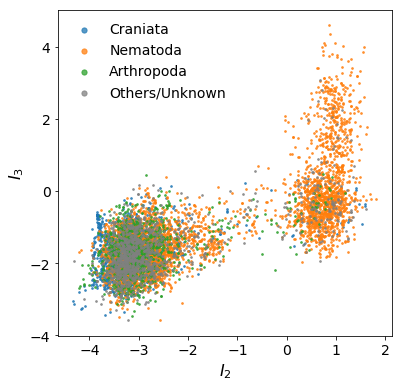

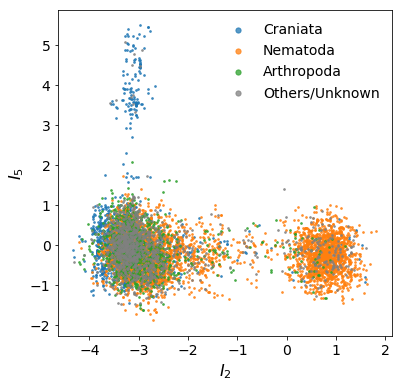

In [23]:
## Phylogenic analysis. Find the evolutionary origin of sequences that strongly activate hidden units 2 and 3

filename = 'Kunitz_domain_MSA.fasta'
filename_info = 'Kunitz_domain_Sequence_origin.data'
path = u'data/Kunitz/'


all_data = Proteins_utils.load_FASTA(path+filename,drop_duplicates=False)
out =pd.DataFrame(all_data).drop_duplicates()
indexes = np.asarray(out.index)
all_data = all_data[indexes,:]

PF14_information = pickle.load(open(path+filename_info,'r'))
liste_organisms = np.array(PF14_information['liste_organisms'])[indexes]
liste_organisms_full_names = np.array(PF14_information['liste_organisms_full_names'])[indexes]
liste_organisms_taxonomy = np.array(PF14_information['liste_organisms_taxonomy'])[indexes]
is_unknown = np.array([ name == 'Unknown' for name in liste_organisms_full_names])



I = RBM.input_hiddens(all_data)
tmp=np.array([x[3] if len(x)>3 else '' for x in liste_organisms_taxonomy])
is_nematode = np.array([x == 'Nematoda' for x in tmp])
is_arthropoda = np.array([x == 'Arthropoda' for x in tmp])
is_craniata = np.array([x == 'Craniata' for x in tmp])
is_other = ~(is_nematode + is_arthropoda + is_craniata)

tmp = I[:,[interesting_features[1],interesting_features[2]]]
            

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(6)
plt.scatter(tmp[is_craniata,0],tmp[is_craniata,1],label='Craniata',s=3,alpha=0.75)
plt.scatter(tmp[is_nematode,0],tmp[is_nematode,1],label='Nematoda',s=3,alpha=0.75)
plt.scatter(tmp[is_arthropoda,0],tmp[is_arthropoda,1],label='Arthropoda',s=3,alpha=0.75)

plt.scatter(tmp[is_other,0],tmp[is_other,1],label='Others/Unknown',s=3,c='grey',alpha=0.75)
plt.xlabel(r'$I_2$',fontsize=16)
plt.ylabel(r'$I_3$',fontsize=16)
plt.legend(fontsize=14,markerscale=3,frameon=False)
for tl in ax.get_xticklabels():
    tl.set_fontsize(14)
for tl in ax.get_yticklabels():
    tl.set_fontsize(14)
plt.show()



tmp = I[:,[interesting_features[1],interesting_features[-1]]]
            

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(6)
plt.scatter(tmp[is_craniata,0],tmp[is_craniata,1],label='Craniata',s=3,alpha=0.75)
plt.scatter(tmp[is_nematode,0],tmp[is_nematode,1],label='Nematoda',s=3,alpha=0.75)
plt.scatter(tmp[is_arthropoda,0],tmp[is_arthropoda,1],label='Arthropoda',s=3,alpha=0.75)

plt.scatter(tmp[is_other,0],tmp[is_other,1],label='Others/Unknown',s=3,c='grey',alpha=0.75)
plt.xlabel(r'$I_2$',fontsize=16)
plt.ylabel(r'$I_5$',fontsize=16)
plt.legend(fontsize=14,markerscale=3,frameon=False)
for tl in ax.get_xticklabels():
    tl.set_fontsize(14)
for tl in ax.get_yticklabels():
    tl.set_fontsize(14)
plt.show()



# Functional Analysis
Analyze the role of the features located around the functional loop of Kunitz that binds to protease

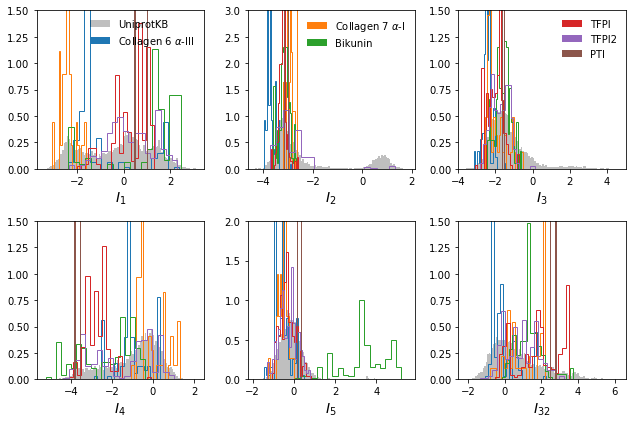

In [24]:
env = pickle.load(open('data/Kunitz/Kunitz_test_sequences.data','r'))
for key,item in env.items():
    globals()[key] = item
    
sequences_test = np.concatenate( (seq_COL6A3,seq_COL7A1,seq_Bikunin,
                                 seq_TFPI, seq_TFPI2, seq_PTI) , axis = 0)

I_test = RBM.input_hiddens(sequences_test)


labels = np.concatenate( (
        np.zeros(seq_COL6A3.shape[0],dtype='int'),
        np.zeros(seq_COL7A1.shape[0],dtype='int') + 1,
        np.zeros(seq_Bikunin.shape[0],dtype='int') + 2,
        np.zeros(seq_TFPI.shape[0],dtype='int') + 3,        
        np.zeros(seq_TFPI2.shape[0],dtype='int') + 4,
        np.zeros(seq_PTI.shape[0],dtype='int') + 5 ), axis = 0 )        
        

label_names = [r'Collagen 6 $\alpha$-III',r'Collagen 7 $\alpha$-I','Bikunin','TFPI','TFPI2','PTI']



if make_training:
    interesting_sites = [60,27,88,77,10,31]
    xlabels = [r'$I_{1}$',r'$I_{2}$',r'$I_{3}$',r'$I_{4}$',r'$I_{5}$',r'$I_{32}$']
else:
    beta = Proteins_RBM_utils.get_beta(RBM.weights)
    order = np.argsort(beta)[::-1]    
    interesting_sites = order[[24,10,51,52,91,33]]
    xlabels = [r'$I_{1}$',r'$I_{2}$',r'$I_{3}$',r'$I_{4}$',r'$I_{5}$',r'$I_{34}$']





fig = plots_utils.plot_input_classes(
    interesting_sites,I,I_test,
    labels,label_names=label_names,
    nbins=20,label_background='UniprotKB',ncols=3,xlabels=xlabels,ymax = [1.5,3,1.5,1.5,2.0,1.5]);




## Sampling from trained RBM.
Combining low-temperature sampling (with the duplicate RBM trick)  and conditional sampling allows to generate high-quality sequences with combinations of features unseen in the MSA.
Here, sequences without the 11-35 disulfide bridge and with the 'AMBP feature' are unseen in nature since these two features occur in different branches of the phylogenic tree. RBM can generate sequences that combine either or both features

List of top activating sequences for hidden unit 5
---------------
-CQLGYSQGPCLGMIKRYFYNGSSMACETFHYGGCMGNGNNFVSEKECLQTCR AMBP_PIG
ACQLGYAEGPCLGMVTRYFYNGSSMACEPFQYGGCLGNGNNFVSEKECLQTCR G1PCS2_MYOLU
ACQLGYAEGPCLGMVRRYFYNGSSMACEPFQYGGCLGNGNNFVSEKECLQTCR S7Q7N6_MYOBR
ACQLGHAEGPCLGMVTRYFYNGSSMACETFQYGGCLGNGNNFASEKECLQTCR M3VU72_FELCA
-CQLGYSAGPCMGMTSRYFYNGTSMACETFQYGGCMGNGNNFVTEKECLQTCR H2QXR0_PANTR
-CQLKHDAGPCLGMTNRYFYNGSSMACEIFQYGGCLGNGNNFVSEKECLQTCR G3U0Y7_LOXAF
-CQLGYAEGPCLGMVRRYFYNGSSMACETFQYGGCLGNGNNFASEKECLQTCR L5K9L7_PTEAL
-CQLGHAEGPCLGMVMRFFYNGSSMACETFQYGGCLGNGNNFASEKECLQTCR G1M2K1_AILME
-CQLGFSQGPCLGMIKRYFYNGSSMACETFHYGGCMGNGNNFISEKECLQTCR S9Y7S2_CAMFR
-CQLGYSAGPCMGMTSRYFYNGTSMACETFQYGGCMGNGNNFITEKECLQTCR G1S4D2_NOMLE
ACQLDHAEGPCLGMVTRYFYNGSSMACETFQYGGCLGNGNNFASEKECLQTCR J9NUI6_CANLF
-CQLGHSAGPCMGMTSRYFYNGTSMACETFQYGGCMGNGNNFMTEKECLQTCR G7PRL7_MACFA
-CQLNYSEGPCLGMQQKYYYNGASMACETFQYGGCLGNGNNFASEKECLQTCR AMBP_RAT
-CQLGYSQGPCLGMFKRYFYNGTSMACETFYYGGCMGNGNNFPSEKECLQTCR IATR_SHEEP
ACQLG

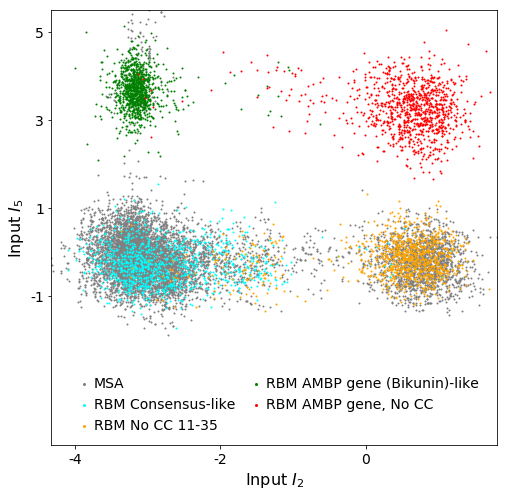

In [25]:
### Conditional Sampling: Generate sequences with prescribed combinations of features 2 and 5, including unseen combinations.


h = RBM.mean_hiddens(all_data)

val_neg = np.zeros(2)
val_pos = np.zeros(2)

i = interesting_features[1]
j = interesting_features[4]

histo =np.histogram(h[:,i],bins=100,weights=all_weights);
count = histo[0]
interval = (histo[1][:-1]+histo[1][1:])/2
val_neg[0] =  interval[interval<0][np.argmax(count[interval<0])]
val_pos[0] =  interval[interval>0][np.argmax(count[interval>0])]


histo =np.histogram(h[:,j],bins=100,weights=all_weights);
count = histo[0]
interval = (histo[1][:-1]+histo[1][1:])/2
val_neg[1] =  interval[interval<0][np.argmax(count[interval<0])]
val_pos[1] =  interval[interval>0][np.argmax(count[interval>0])]

if make_training:
    subgroup = np.argsort(h[:,j] )[::-1][:40] # Top 40 most activating sequences 
else:
    subgroup = np.argsort(h[:,j] )[:40]    
    
subgroup_seq = Proteins_utils.num2seq(all_data[subgroup,:] )
subgroup_h = h[subgroup,j]
subgroup_name = liste_organisms[subgroup]
print 'List of top activating sequences for hidden unit 5'
print '---------------'
for seq,name in zip(subgroup_seq,subgroup_name):
    print seq,name    
print '---------------'        

if make_training:
    val_pos[1] = subgroup_h.mean()        
else:
    val_neg[1] = subgroup_h.mean()        
    

    
# Define conditions, as a list of tuples (index, value)
cond1 = [(i,val_neg[0]), (j,val_neg[1]) ] 
cond3 = [(i,val_neg[0]), (j,val_pos[1]) ]

if make_training:
    cond2 = [(i,val_pos[0]), (j,val_neg[1]) ]
    cond4 = [(i,val_pos[0]*2), (j,val_pos[1]) ]    
else:
    cond2 = [(i,val_pos[0]*2), (j,val_neg[1]) ]
    cond4 = [(i,val_pos[0]), (j,val_pos[1]) ]    


# Build new conditional RBMs, with M-2 hidden units.
condRBM1 = Proteins_RBM_utils.conditioned_RBM(RBM,cond1)
condRBM2 = Proteins_RBM_utils.conditioned_RBM(RBM,cond2)
condRBM3 = Proteins_RBM_utils.conditioned_RBM(RBM,cond3)
condRBM4 = Proteins_RBM_utils.conditioned_RBM(RBM,cond4)


# Generate sequences.
N_sequences = 1000
Nstep = 10


datav1,datah1 = condRBM1.gen_data(Nchains = 100, Lchains = N_sequences/100,Nstep=Nstep,Nthermalize=500)
datav2,datah2 = condRBM2.gen_data(Nchains = 100, Lchains = N_sequences/100,Nstep=Nstep,Nthermalize=500)
datav3,datah3 = condRBM3.gen_data(Nchains = 100, Lchains = N_sequences/100,Nstep=Nstep,Nthermalize=500)
datav4,datah4 = condRBM4.gen_data(Nchains = 100, Lchains = N_sequences/100,Nstep=Nstep,Nthermalize=500)
   

if make_training: # Signs of the weights can change from a training to the other...
    data_regular = datav1
    data_noCC = datav2    
    data_ambp = datav3
    data_ambp_noCC = datav4 # Unseen combination in data
else:
    data_regular = datav3
    data_noCC = datav4
    data_ambp = datav1
    data_ambp_noCC = datav2 # Unseen combination in data
    
if make_training:
    data_regular_lowT, _ = Proteins_RBM_utils.gen_data_lowT(condRBM1, beta = 2, Nchains = 100, Lchains = N_sequences/100,Nstep=Nstep,Nthermalize=500)
    data_ambp_noCC_lowT, _ = Proteins_RBM_utils.gen_data_lowT(condRBM4, beta = 2, Nchains = 100, Lchains = N_sequences/100,Nstep=Nstep,Nthermalize=500)    
else:
    data_regular_lowT, _ = Proteins_RBM_utils.gen_data_lowT(condRBM3, beta = 2, Nchains = 100, Lchains = N_sequences/100,Nstep=Nstep,Nthermalize=500)
    data_ambp_noCC_lowT, _ = Proteins_RBM_utils.gen_data_lowT(condRBM2, beta = 2, Nchains = 100, Lchains = N_sequences/100,Nstep=Nstep,Nthermalize=500)
    

I = RBM.input_hiddens(all_data)
I_ambp = RBM.input_hiddens(data_ambp)
I_regular = RBM.input_hiddens(data_regular)
I_noCC = RBM.input_hiddens(data_noCC)
I_ambp_noCC = RBM.input_hiddens(data_ambp_noCC)



#%%
s1 = 1.0
s2 = 1.0

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
ax.scatter(I[:,i], I[:,j],c='gray',s=s1,label='MSA')
ax.scatter(I_regular[:,i], I_regular[:,j],c='cyan',s=s2,label='RBM Consensus-like')
ax.scatter(I_noCC[:,i], I_noCC[:,j],c='orange',s=s2,label = 'RBM No CC 11-35')
ax.scatter(I_ambp[:,i], I_ambp[:,j],c='green',s=s2,label='RBM AMBP gene (Bikunin)-like')
ax.scatter(I_ambp_noCC[:,i], I_ambp_noCC[:,j],c='red',s=s2,label='RBM AMBP gene, No CC')
plt.xlabel('Input $I_2$',fontsize=16)
plt.ylabel('Input $I_5$',fontsize=16)
xmin = I[:,i].min()
xmax = I[:,i].max()
ax.set_xlim([xmin,xmax])
step = int( (xmax-xmin )/4.0) +1
xticks = np.arange(int(xmin), int(xmax)+1, step)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize=14)

ymin = I[:,j].min()
ymax = I[:,j].max()
ax.set_ylim([ymin -2.5,ymax])
step = int( (ymax-ymin )/4.0) +1
yticks = np.arange(int(ymin), int(ymax)+1, step)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks,fontsize=14) 
plt.legend(ncol=2,fontsize=14,frameon=False,handletextpad=-0.3,markerscale=2,loc='lower center',columnspacing=0.5)
fig.show()

## Proximity with sequences from the alignment.
A good generative model should produce sequences that are reasonibly far away from the training set. Conversely, sequences that are too far away should have low likelihood and a trade-off exists.

For each generated sequence, we compute its likelihood and distance to the closest natural sequence.



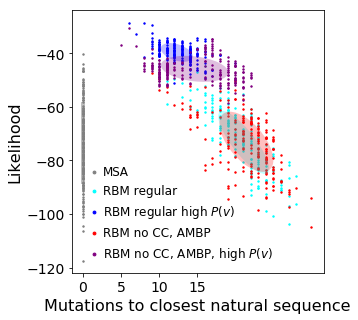

In [26]:
# ## Visualize likelihood vs distance to closest sequence.

from matplotlib import patches

def distance_to_natural(synth_seq,nat_seq): # For each seq in synth_seq, compute the distance to the closest natural sequence 
    min_dists = []
    for seq in synth_seq:
        min_dists.append ((seq[np.newaxis,:] <> nat_seq).mean(1).min() )
    return np.array(min_dists)



nmax = 200
N = 53

subset_nat = np.argsort(np.random.rand(all_data.shape[0]))[:nmax]
subset_synth = np.argsort(np.random.rand(data_regular.shape[0]))[:nmax]


d_regular = distance_to_natural(data_regular,all_data)
d_regular_lowT = distance_to_natural(data_regular_lowT,all_data)
d_ambp_noCC = distance_to_natural(data_ambp_noCC,all_data)
d_ambp_noCC_lowT = distance_to_natural(data_ambp_noCC_lowT,all_data)


lik_nat = RBM.likelihood(all_data)
lik_regular = RBM.likelihood(data_regular)
lik_regular_lowT = RBM.likelihood(data_regular_lowT)
lik_ambp_noCC = RBM.likelihood(data_ambp_noCC)
lik_ambp_noCC_lowT = RBM.likelihood(data_ambp_noCC_lowT)


s1 = 14
s2 = 16
s3 = 2
s4 =12


off = 0.15

fig , ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(5)
fig.subplots_adjust(left=0.2,bottom=0.15)
plt.scatter(np.zeros(nmax), lik_nat[subset_nat], marker='o', s = s3, c = 'gray',label='MSA');
plt.scatter(d_regular[subset_synth]*N, lik_regular[subset_synth], marker='o', s = s3, c = 'cyan',label='RBM regular')
plt.scatter(d_regular_lowT[subset_synth]*N, lik_regular_lowT[subset_synth], marker='o', s = s3, c = 'blue',label=r'RBM regular high $P(v)$')
plt.scatter(d_ambp_noCC[subset_synth]*N, lik_ambp_noCC[subset_synth], marker='o', s = s3, c = 'red',label=r'RBM no CC, AMBP');
plt.scatter(d_ambp_noCC_lowT[subset_synth]*N, lik_ambp_noCC_lowT[subset_synth], marker='o', s = s3, c = 'purple',label=r'RBM no CC, AMBP, high $P(v)$');



mu = lik_nat.mean()
std = lik_nat.std()
w = 0.5

rec = patches.Rectangle(xy=(-w/2, mu-std),
              width=w, height=2*std)
rec.set_facecolor('gray')
rec.set_alpha(0.5)
ax.add_artist(rec)


mu_dists = (d_regular*N).mean()
mu_lik = lik_regular.mean()
covariance = np.cov(d_regular*N,  lik_regular )

lam,v = np.linalg.eigh(covariance)

ell = patches.Ellipse(xy=(mu_dists, mu_lik),
              width=np.sqrt(lam)[0]*2, height=np.sqrt(lam)[1]*2,
              angle=np.rad2deg(-np.arccos(v[0, 0])))
ell.set_facecolor('cyan')
ell.set_alpha(0.25)
ax.add_artist(ell)

mu_dists = (d_regular_lowT*N).mean()
mu_lik = lik_regular_lowT.mean()
covariance = np.cov(d_regular_lowT*N,  lik_regular_lowT )

lam,v = np.linalg.eigh(covariance)

ell = patches.Ellipse(xy=(mu_dists, mu_lik),
              width=np.sqrt(lam)[0]*2, height=np.sqrt(lam)[1]*2,
              angle=np.rad2deg(-np.arccos(v[0, 0])))
ell.set_facecolor('blue')
ell.set_alpha(0.25)
ax.add_artist(ell)

mu_dists = (d_ambp_noCC*N).mean()
mu_lik = lik_ambp_noCC.mean()
covariance = np.cov(d_ambp_noCC*N,  lik_ambp_noCC )

lam,v = np.linalg.eigh(covariance)

ell = patches.Ellipse(xy=(mu_dists, mu_lik),
              width=np.sqrt(lam)[0]*2, height=np.sqrt(lam)[1]*2,
              angle=np.rad2deg(-np.arccos(v[0, 0])))
ell.set_facecolor('red')
ell.set_alpha(0.25)
ax.add_artist(ell)


mu_dists = (d_ambp_noCC_lowT*N).mean()
mu_lik = lik_ambp_noCC_lowT.mean()
covariance = np.cov(d_ambp_noCC_lowT*N,  lik_ambp_noCC_lowT )

lam,v = np.linalg.eigh(covariance)

ell = patches.Ellipse(xy=(mu_dists, mu_lik),
              width=np.sqrt(lam)[0]*2, height=np.sqrt(lam)[1]*2,
              angle=np.rad2deg(-np.arccos(v[0, 0])))
ell.set_facecolor('purple')
ell.set_alpha(0.25)
ax.add_artist(ell)

x = [0,5,10,15]
ax.set_xticks(x)
ax.set_xticklabels(x,fontsize=s1);
ax.set_xlabel('Mutations to closest natural sequence',fontsize=s2)
ax.set_ylabel('Likelihood',fontsize=s2)


for tl in ax.get_xticklabels():
    tl.set_fontsize(s1)
for tl in ax.get_yticklabels():
    tl.set_fontsize(s1)    
plt.legend(fontsize=s4,frameon=False,loc='lower left',markerscale=2,handletextpad=-0.3)


